In [5]:
from sympy import N
from state import *
from math import sqrt
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [32]:
def fwh_TTD( m_dot_D, h_D_in, P_D, m_dot_FW, h_FW_in, P_FW, h_T_in, P_T, DT_TTD, DT, N_hxrs): 
    
    # m_T, h_FW_out, h_D_out,T_H[1..3*N_hxrs+1], T_C[1..3*N_hxrs+1])
	
    # $VarInfo h_H[] units='J/kg'
	# $VarInfo h_C[] units='J/kg'
	# $VarInfo T_H[] units='K' lower = 273 upper = 5000
	# $VarInfo T_C[] units='K' lower = 273 upper = 5000
	# $VarInfo q_dot[] units='W'
	# $VarInfo DELTA_T[] units='K'
	# $VarInfo m_T units='kg/s' lower = 1 upper = 100
 
	# $VarInfo q_dot_tot units='W' lower = 0 
	# $VarInfo q_dot_ds units='W' lower = 0 
	# $VarInfo q_dot_hx units='W' lower = 0 
	# $VarInfo q_dot_cond units='W' lower = 0 

    # Calculate the minimum enthalpy
    # h_min = enthalpy(T=t_sat(2000), X=0.)
    # # Calculate the maximum mass flow rate that can be condensed while keeping above the min. enthalpy
    # # h_T_vap = enthalpy( P = P_T, T = (t_sat( P = P_T)+0.01))
    # h_T_vap = enthalpy( P = P_T, X = 1)
    # h_T_out = enthalpy( T = T_T_out, P = P_T)
    # q_dot_cond = m_c*(h_T_vap-h_T_out)
    # h_H[1] = h_T_in
    # T_H[1] = T_T_in
    # h_H[i] = h_H[i-1]-q_dot_cond/(N_hxrs*m_c)

    m_c_log = []
    m_d_log = []
    iter_log = []
    err_log = [] 
    DT_TTD_c_log = []
    DT_TTD_d_log = []   
    iter = 1
    m_a = .1 #[kg/s]	#lower limit on mass flow
    m_b = 100 #[kg/s]	#upper limit on mass flow
    tol = 0.0001 #[kg/s]	#convergence tolerance
    err = tol*999
    gr = (1+sqrt(5))/2	#golden ratio
    m_c = m_b - (m_b-m_a)/(gr)	#middle sections for golden section search
    m_d = m_a + (m_b-m_a)/(gr)
    while(err>tol):
        err = abs(m_b-m_a)
        #function c --------------------------- 
        T_T_in = temperature( P = P_T, H = h_T_in)
        T_T_out = t_sat( P = P_T) - 0.01 #[K]
        h_T_out = enthalpy( T = T_T_out, P = P_T)
        m_dot_D_int = m_c+m_dot_D
        h_D_int = (m_c*h_T_out+m_dot_D*h_D_in)/m_dot_D_int

        if P_D > 0:
            P_D_int = min(P_D, P_T)
        else:
            P_D_int = P_T

        T_D_int = temperature( H = h_D_int, P = P_D_int)
        T_FW_in = temperature( H = h_FW_in, P = P_FW)
        T_D_out = T_FW_in+DT
        h_D_out = enthalpy( T = T_D_out, P = P_D_int)
        q_dot_hx = m_dot_D_int*(h_D_int-h_D_out)
        h_FW_int = h_FW_in + q_dot_hx/m_dot_FW
        # T_FW_int = temperature( H = h_FW_int, P = P_FW)
        q_dot_ds__cond = m_c*(h_T_in-h_T_out)
        h_FW_out = h_FW_int+q_dot_ds__cond / m_dot_FW
        T_FW_out = temperature( H = h_FW_out, P = P_FW)
        # q_dot_tot = m_dot_FW*(h_FW_out - h_FW_in)
        
        h_T_vap = enthalpy( P = P_T, T = (t_sat( P = P_T)+0.01))
        h_T_vap = min(h_T_vap, h_T_in) #correct this if entering with quality< 1 <<<< MJW
        q_dot_cond = m_c*(h_T_vap-h_T_out)
        
        if h_T_in - h_T_vap > 0:
            q_dot_ds = m_c*(h_T_in - h_T_vap)
        else:
            q_dot_ds = 0 #[W]
        
        # {q_dot_ds = m_c*(h_T_in - h_T_vap)}
        #ds
        nn = 3*N_hxrs+2
        h_H = np.zeros(nn)
        T_H = np.zeros(nn)
        h_C = np.zeros(nn)
        T_C = np.zeros(nn)
        DELTA_T = np.zeros(nn)

        h_H[1] = h_T_in
        T_H[1] = T_T_in
        h_C[1] = h_FW_out 
        T_C[1] = T_FW_out 
        #ds
        for i in range(2,(N_hxrs+1)+1) : 	#building hot enthalpy and temperature array
            h_H[i] = h_H[i-1]-q_dot_ds/(N_hxrs*m_c)
            T_H[i] = temperature(H = h_H[i],P=P_T)
        for i in range(2,(N_hxrs+1)+1) : 	#building cold enthalpy and temperature array
            h_C[i] = h_C[i-1]-q_dot_ds/(N_hxrs*m_dot_FW)	
            T_C[i]=temperature(H = h_C[i],P=P_FW)	
        #cond
        for i in range((N_hxrs+2),(2*N_hxrs)+1) : 	#building hot enthalpy and temperature array
            h_H[i] = h_H[i-1]-q_dot_cond/(N_hxrs*m_c)
            T_H[i] = temperature(H = h_H[i],P=P_T)
        for i in range((N_hxrs+2),(2*N_hxrs+1)+1) : 	#building cold enthalpy and temperature array
            h_C[i] = h_C[i-1]-q_dot_cond/(N_hxrs*m_dot_FW)	
            T_C[i]=temperature(H = h_C[i],P=P_FW)	
        h_H[2*N_hxrs+1] = h_D_int	#drain addition enthalpy
        T_H[2*N_hxrs+1] =  T_D_int	#drain addition temperature
        #hx
        for i in range((2*N_hxrs+2),(3*N_hxrs+1)+1) : 	#building hot enthalpy and temperature array
            h_H[i] = h_H[i-1]-q_dot_hx/(N_hxrs*m_dot_D_int)
            T_H[i] = temperature(H = h_H[i],P=P_D_int)
        for i in range((2*N_hxrs+2),(3*N_hxrs+1)+1) : 	#building cold enthalpy and temperature array
            h_C[i] = h_C[i-1]-q_dot_hx/(N_hxrs*m_dot_FW)	
            T_C[i]=temperature(H = h_C[i],P=P_FW)	
        for i in range(1,(3*N_hxrs+1)+1) : 
            DELTA_T[i] = T_H[i] - T_C[i]
        pinch_c = min(DELTA_T[1:2*N_hxrs+2+1])
        DT_TTD_c = T_FW_out - (t_sat( P = P_T)+0.01)
        diff_c = abs(DT_TTD - DT_TTD_c)

        #function d ---------------------------------------------------------- 
        T_T_in = temperature( P = P_T, H = h_T_in)
        T_T_out = t_sat( P = P_T) - 0.01 #[K]
        h_T_out = enthalpy( T = T_T_out, P = P_T)
        m_dot_D_int = m_d+m_dot_D
        h_D_int = (m_d*h_T_out+m_dot_D*h_D_in)/m_dot_D_int
        if P_D > 0:
            P_D_int = min(P_D, P_T)
        else:
            P_D_int = P_T
        
        T_D_int = temperature( H = h_D_int, P = P_D_int)
        T_FW_in = temperature( H = h_FW_in, P = P_FW)
        T_D_out = T_FW_in+DT
        h_D_out = enthalpy( T = T_D_out, P = P_D_int)
        q_dot_hx = m_dot_D_int*(h_D_int-h_D_out)
        h_FW_int = h_FW_in + q_dot_hx/m_dot_FW
        # T_FW_int = temperature( H = h_FW_int, P = P_FW)
        q_dot_ds__cond = m_d*(h_T_in-h_T_out)
        h_FW_out = h_FW_int+q_dot_ds__cond / m_dot_FW
        T_FW_out = temperature( H = h_FW_out, P = P_FW)
        # q_dot_tot = m_dot_FW*(h_FW_out - h_FW_in)
        
        h_T_vap = enthalpy( P = P_T, T = (t_sat( P = P_T)+0.01))
        h_T_vap = min(h_T_vap, h_T_in) #correct this if entering with quality< 1 <<<< MJW
        q_dot_cond = m_d*(h_T_vap-h_T_out)
        
        if h_T_in - h_T_vap > 0:
            q_dot_ds = m_c*(h_T_in - h_T_vap)
        else:
            q_dot_ds = 0 #[W]
        # {
        # q_dot_ds = m_d*(h_T_in - h_T_vap)}
        #ds
        h_H[1] = h_T_in
        T_H[1] = T_T_in
        h_C[1] = h_FW_out 
        T_C[1] = T_FW_out 
        #ds
        for i in range(2,(N_hxrs+1)+1) : 	#building hot enthalpy and temperature array
            h_H[i] = h_H[i-1]-q_dot_ds/(N_hxrs*m_d)
            T_H[i] = temperature(H = h_H[i],P=P_T)
        for i in range(2,(N_hxrs+1)+1) : 	#building cold enthalpy and temperature array
            h_C[i] = h_C[i-1]-q_dot_ds/(N_hxrs*m_dot_FW)	
            T_C[i]=temperature(H = h_C[i],P=P_FW)	
        #cond
        for i in range((N_hxrs+2),(2*N_hxrs)+1) : 	#building hot enthalpy and temperature array
            h_H[i] = h_H[i-1]-q_dot_cond/(N_hxrs*m_d)
            T_H[i] = temperature(H = h_H[i],P=P_T)
        for i in range((N_hxrs+2),(2*N_hxrs+1)+1) : 	#building cold enthalpy and temperature array
            h_C[i] = h_C[i-1]-q_dot_cond/(N_hxrs*m_dot_FW)	
            T_C[i]=temperature(H = h_C[i],P=P_FW)	
        h_H[2*N_hxrs+1] = h_D_int	#drain addition enthalpy
        T_H[2*N_hxrs+1] =  T_D_int	#drain addition temperature
        #hx
        for i in range((2*N_hxrs+2),(3*N_hxrs+1)+1) : 	#building hot enthalpy and temperature array
            h_H[i] = h_H[i-1]-q_dot_hx/(N_hxrs*m_dot_D_int)
            T_H[i] = temperature(H = h_H[i],P=P_D_int)
        for i in range((2*N_hxrs+2),(3*N_hxrs+1)+1) : 	#building cold enthalpy and temperature array
            h_C[i] = h_C[i-1]-q_dot_hx/(N_hxrs*m_dot_FW)	
            T_C[i]=temperature(H = h_C[i],P=P_FW)	
        for i in range(1,(3*N_hxrs+1)+1): 
            DELTA_T[i] = T_H[i] - T_C[i]
        pinch_d = min(DELTA_T[1:2*N_hxrs+2+1])
        DT_TTD_d = T_FW_out - (t_sat( P = P_T)+0.01)
        diff_d = abs(DT_TTD - DT_TTD_d)

        # Log m_c and m_d values for each iter:
        m_c_log.append(m_c)
        m_d_log.append(m_d)
        err_log.append(err)
        iter_log.append(iter)
        DT_TTD_c_log.append(DT_TTD_c)
        DT_TTD_d_log.append(DT_TTD_d)
        #golden section search iteration
        if diff_c < diff_d:
            m_b = m_d
        else:
            m_a = m_c
        m_c = m_b - (m_b -m_a)/gr
        m_d = m_a + (m_b-m_a)/gr
        iter = iter + 1
        #print("iter:" + str(iter) + " -- error: " + str(err))

    m_T = (m_b+m_a)/2
    # print("Pinch: {:.2f}:{:.2f} ".format(pinch_c,pinch_d), end="")
    return [
        m_T, 
        h_FW_out, 
        h_D_out,
        T_H[1:3*N_hxrs+1+1], 
        T_C[1:3*N_hxrs+1+1],
        m_c_log,
        m_d_log,
        err_log,
        iter_log,
        # pinch_c, 
        # pinch_d,
    ]

In [7]:
# get input state data -- as per Wang's paper
## Test model

# //constants for testing code
m_given = [0, 619.385, 619.385,68.802,15.98,670.831,670.831,522.217,39.407,438.914,\
43.896,438.914,19.4,24.018, 28.702,366.794,25.599,12.993,17.286,13.574,297.343,\
29813.6,29813.6,395.497,395.497,395.497,395.497,395.497,395.497,522.217,522.217,\
522.217,522.217,522.217,39.407,83.303,102.702,25.599,38.592,55.878,69.452,28.702]
T_celc = [0, 25,330.41,25,600,394,127,571,364.23,304.98,304.98,569,459.68,362.68,\
362.68,362.68,253.53,128.72,88.19,60.94,35.79,25,30.79,35.79,35.94,58.16,85.41,\
105.06,143.24,180.06,185.59,211.95,253.27,284.05,258.82,217.5,191.14,110.61,90.96,\
63.71,41.49, 39.68]
T_given = np.array(T_celc)+273.15

P_bar = [0, 1.002,1,1,1,0.998,0.978,254,67.97,43,43,41.1,20.58,10.44,10.44,10.44,4.374,\
    1.333,0.655,0.208,0.059,1,1,0.059,17.24,15.84,14.54,12.94,11.44,10.04,308.7,303.7,298.4,\
    293.5,64.97,41,19.08,4.174,1.333,0.655,0.208,0.073]
    
P_given = np.array(P_bar)*100000.
h_given = np.zeros(len(P_given))
for i in range(1,len(h_given)):
    h_given[i] = enthalpy(P=P_given[i], T=T_given[i])

# Prepare test arrays
HX = [1,2,3,5,6,7,8]
# drain in
m_D_in = [0,m_given[34],m_given[35],0,m_given[37],m_given[38],m_given[39]]
h_D_in = [0,h_given[34],h_given[35],0,h_given[37],h_given[38],h_given[39]]
P_D = [0,P_given[34],P_given[35],0,P_given[37],P_given[38],P_given[39]]

# turbine in
m_T_check = [m_given[8],m_given[10],m_given[12],m_given[16],m_given[17],m_given[18],m_given[19]]
P_T = [P_given[8],P_given[10],P_given[12],P_given[16],P_given[17],P_given[18],P_given[19]]
h_T = [h_given[8],h_given[10],h_given[12],h_given[16],h_given[17],h_given[18],h_given[19]]
T_T = [T_given[8],T_given[10],T_given[12],T_given[16],T_given[17],T_given[18],T_given[19]]

# fwh in
m_dot_FW = [m_given[32],m_given[31],m_given[30],m_given[27],m_given[26],m_given[25],m_given[24]]
P_FW = [P_given[32],P_given[31],P_given[30],P_given[27],P_given[26],P_given[25],P_given[24]]
h_FW = [h_given[32],h_given[31],h_given[30],h_given[27],h_given[26],h_given[25],h_given[24]]
T_FW_in = [T_given[32],T_given[31],T_given[30],T_given[27],T_given[26],T_given[25],T_given[24]]

# FW out
m_dot_FW_out = [m_given[33],m_given[32],m_given[31],m_given[28],m_given[27],m_given[26],m_given[25]]
T_FW_out = [T_given[33],T_given[32],T_given[31],T_given[28],T_given[27],T_given[26],T_given[25]]

# Approach Temp + TTD
DT = 5.55
P_sat  = np.zeros(len(HX))
T_sat  = np.zeros(len(HX))
DT_TTD  = np.zeros(len(HX))
N_hxrs = 30

ret = np.zeros(len(HX))
err_check = np.zeros(len(HX))

for i in range(len(HX)):
    P_sat[i] = P_T[i]
    T_sat[i] = t_sat( P = P_sat[i])+0.01
    DT_TTD[i] = T_FW_out[i] - T_sat[i]

In [28]:
## solve HX7
m_D_in_check = 38.592 #[kg/s]
T_D_in_check = 90.96 + 273.15
P_D_in_check = 1.333*100000
h_D_in_check = enthalpy(P=P_D_in_check,T=T_D_in_check)

m_T_in_check = 17.286
T_T_in_check = 88.19 + 273.15
P_T_in_check = 0.655*100000
h_T_in_check = enthalpy(P=P_T_in_check,T=T_T_in_check)

m_fw_in_check = 395.497
T_fw_in_check = 58.16 + 273.15
P_fw_in_check = 15.84 *100000
h_fw_in_check = enthalpy(P=P_fw_in_check,T=T_fw_in_check)

T_fw_out_check = 80.11 + 273.15

P_sat_check = P_T_in_check
T_sat_check = t_sat( P = P_sat_check)+0.06
DT_TTD_check = T_fw_out_check - T_sat_check
res_HX7 = fwh_TTD( m_D_in_check, h_D_in_check, P_D_in_check, m_fw_in_check, h_fw_in_check, P_fw_in_check, h_T_in_check, P_T_in_check, DT_TTD_check, DT, N_hxrs)

In [29]:
# get ans array
m_c_log = res_HX7[5]
m_d_log = res_HX7[6]
err_log = res_HX7[7]
iter_log = res_HX7[8]

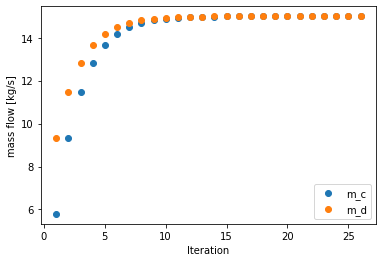

In [30]:
#Build plots
fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.scatter(iter_log,m_c_log)
ax1.scatter(iter_log, m_d_log)
plt.xlabel('Iteration')
plt.ylabel('mass flow [kg/s]')
ax1.legend(["m_c","m_d"],loc='lower right')

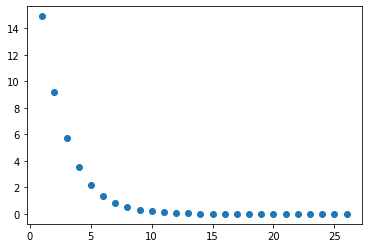

In [31]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(iter_log,err_log)

In [15]:
res_HX7[0]

49.99997830153646

In [36]:
# simple explicit model to check DT_TTD
h_in_7 = (m_D_in[5]*h_D_in[5] + m_T_check[5]*h_T[5])/(m_D_in[5] + m_T_check[5])
Q_dot_1 = m_dot_FW[5] * (h_FW)